## Econometric estimation of an IRL-based market portfolio model

Welcome to your final course project on RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns that is based on IRL of a market-optimal portfolio 
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
- Compare simple IRL-based and UL-based trading strategies

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Complete the model estimation for the DJI portfolio of 30 stocks, and simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Propose other signals and investigate the dynamics for market caps obtained with alternative signals. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Can you repeat your analysis for the S&P portfolio? You will have to build a data file, build signals, and repeat the model estimation process with your new dataset (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis. For example, you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your first IRL based model of market dynamics, and learn how this IRL approach extends the famous Black-Litterman model (see F. Black and R. Litterman, "Global Portfolio Optimization", Financial Analyst Journal, Sept-Oct. 1992, 28-43, and  D. Bertsimas, V. Gupta, and I.Ch. Paschalidis, "Inverse Optimization: A New Perspective on the Black-Litterman Model", Operations Research, Vol.60, No.6, pp. 1389-1403 (2012), I.Halperin and I. Feldshteyn "Market Self-Learning of Signals, Impact and Optimal Trading: Invisible Hand Inference with Free Energy", https://papers.ssrn.com/sol3/papers.cfm?abstract\_id=3174498.). 
- Know how to enhance a market-optimal portfolio policy by using your private signals. 
- Be able to implement trading strategies based on this method.

Let's get started!

## The IRL-based model of stock returns

In Week 4 lectures of our course we found that optimal investment policy in the problem of inverse portfolio optimization is a Gaussian policy

$$ \pi_{\theta}({\bf a}_t |{\bf y}_t ) =   \mathcal{N}\left({\bf a}_t | \bf{A}_0 + \bf{A}_1 {\bf y}_t, \Sigma_p \right) $$

Here $ {\bf y}_t $ is a vector of dollar position in the portfolio, and $ \bf{A}_0 $, $ \bf{A}_1 $ and $ \Sigma_p $ are parameters defining a Gaussian policy.   

We said in the lecture that such Gaussian policy is found for both cases of a single investor and a market portfolio. We also sketched a numerical scheme that can iteratively compute coefficients $ \bf{A}_0$, $ \bf{A}_1 $ and $ \Sigma_p $ using a combination of a RL algorithm called G-learning and a trajectory optimization algorithm.

In this project, you will explore implications and estimation of this IRL-based model for the most interesting case - the market portfolio. It turns out that for this case, the model can be estimated in an easier way using a conventional Maximum Likelihood approach. To this end, we will re-formulate the model for this particular case in three easy steps.


Recall that for a vector of $ N $ stocks, we introduced a size $ 2 N $-action vector 
$ {\bf a}_t = [{\bf u}_t^{(+)}, {\bf u}_t^{(-)}] $, so that an action $ {\bf u}_t $ was defined as a difference of two non-negative numbers 
$ {\bf u}_t = {\bf u}_t^{(+)} -  {\bf u}_t^{(-)} = [{\bf 1}, - {\bf 1}] {\bf a}_t \equiv {\bf 1}_{-1}^{T} {\bf a}_t $.

Therefore, the joint distribution of $ {\bf a}_t = [{\bf u}_t^{(+)}, {\bf u}_t^{(-)} ] $ is given by our Gaussian policy
$  \pi_{\theta}({\bf a}_t |{\bf y}_t ) $. This means that the distribution of 
$ {\bf u}_t = {\bf u}_t^{(+)} -  {\bf u}_t^{(-)} $ is also Gaussian. Let us write it therefore as follows:

$$
\pi_{\theta}({\bf u}_t |{\bf y}_t ) =   \mathcal{N}\left({\bf u}_t | \bf{U}_0 + \bf{U}_1 {\bf y}_t, \Sigma_u \right) 
$$

Here $ \bf{U}_0 = {\bf 1}_{-1}^{T}  \bf{A}_0 $ and $ \bf{U}_1 =  {\bf 1}_{-1}^{T}  \bf{A}_1 $.

This means that $ {\bf u}_t $ is a Gaussian random variable that we can write as follows:

$$
{\bf u}_t = \bf{U}_0 + \bf{U}_1 {\bf y}_t + \varepsilon_t^{(u)}  = \bf{U}_0 + \bf{U}_1^{(x)} {\bf x}_t + \bf{U}_1^{(z)} {\bf z}_t + \varepsilon_t^{(u)} 
$$

where $ \varepsilon_t^{(u)} \sim \mathcal{N}(0,\Sigma_u) $ is a Gaussian random noise.  

The most important feature of this expression that we need going forward is is linear dependence on the state $ {\bf x}_t $. 
This is the only result that we will use in order to construct a simple dynamic market model resulting from our IRL model. We use a deterministic limit of this equation, where in addition we set $ \bf{U}_0 = \bf{U}_1^{(z)} = 0 $, and replace $ \bf{U}_1^{(x)} \rightarrow \phi $ to simplify the notation. We thus obtain a simple deterministic policy

$$
\label{determ_u}
{\bf u}_t =  \phi  {\bf x}_t 
$$

Next, let us recall the state equation and return equation (where we reinstate a time step $ \Delta t $,
and $ \circ $ stands for an element-wise (Hadamard) product):

$$
X_{t+ \Delta t} = (1 + r_t \Delta t) \circ (  X_t +  u_t  \Delta t)  
$$
$$
r_t   = r_f + {\bf w} {\bf z}_t -  \mu  u_t + \frac{\sigma}{ \sqrt{ \Delta t}} \varepsilon_t 
$$
where $ r_f $ is a risk-free rate, $ \Delta t $ is a time step, $ {\bf z}_t $ is a vector of predictors with weights $ {\bf w} $, $ \mu $ is a market impact parameter with a linear impact specification, and $ \varepsilon_t \sim \mathcal{N} (\cdot| 0, 1) $ is a white noise residual.


Eliminating $ u_t $ from these expressions and simplifying, we obtain
$$ \Delta  X_t = \mu  \phi  ( 1 + \phi \Delta t) \circ  X_t \circ \left(  \frac{r_f (1 + \phi \Delta t)  + \phi}{ \mu \phi (1+ \phi \Delta t )}  -  X_t \right) \Delta t + 
( 1 + \phi \Delta t) X_t  \circ \left[ {\bf w} {\bf z}_t  \Delta t +  \sigma \sqrt{ \Delta t} \varepsilon_t \right]
$$
Finally, assuming that $ \phi \Delta t \ll 1 $ and taking the continuous-time limit $  \Delta t \rightarrow dt $, we obtain 

$$
d X_t = \kappa \circ X_t \circ \left( \frac{\theta}{\kappa} - X_t \right) dt +  X_t \circ \left[ {\bf w} {\bf z}_t \, dt + \sigma d W_t \right]
$$
where $\kappa   =   \mu  \phi $, $ \theta  =   r_f + \phi $, and $ W_t $ is a standard Brownian motion.

Please note that this equation describes dynamics with a quadratic mean reversion. It is quite different from models with linear mean reversion such as the Ornstein-Uhlenbeck (OU) process. 

Without signals $ {\bf z}_t $, this process is known in the literature as a Geometric Mean Reversion (GMR) process. It has been used (for a one-dimensional setting) by Dixit and Pyndick (" Investment Under Uncertainty", Princeton 1994), and investigated (also for 1D) by Ewald and Yang ("Geometric Mean Reversion: Formulas for the Equilibrium Density and Analytic Moment Matching", {\it University of 
St. Andrews Economics Preprints}, 2007). We have found that such dynamics (in a multi-variate setting) can also be obtained for market caps (or equivalently for stock prices, so long as the number of shares is held fixed) using Inverse Reinforcement Learning! 

(For more details, see I. Halperin and I. Feldshteyn, "Market Self-Learning of Signals, Impact and Optimal Trading: Invisible Hand Inference with Free Energy.
(or, How We Learned to Stop Worrying and Love Bounded Rationality)", https://papers.ssrn.com/sol3/papers.cfm?abstract\_id=3174498) 


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
tf.__version__

'1.10.1'

In [3]:
tf.set_random_seed(97)

In [4]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')

In [5]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.937537e+11,48660795480,4.082033e+10,36460724400,1.420313e+11,1.586155e+11,6.168697e+10,3.337392e+10,1.645038e+11,8.897731e+10,...,25598248500,1.527563e+11,178576382080,27214839130,36638396010,67155918570,41337043020,94536765440,206625627560,3.272107e+11
2010-01-05,1.940887e+11,48553770270,4.215727e+10,36896634000,1.413985e+11,1.597391e+11,6.153308e+10,3.486077e+10,1.653556e+11,9.055040e+10,...,25700093100,1.505775e+11,178634816760,26570118990,36580295160,66152751840,40863360090,94707204320,204568134680,3.284884e+11
2010-01-06,1.910015e+11,49338621810,4.343609e+10,37008725040,1.404781e+11,1.597591e+11,6.120609e+10,3.547838e+10,1.645038e+11,8.958393e+10,...,25543409100,1.500934e+11,177787513900,26193121620,36940520430,65805862410,40314638280,90673484160,204110914040,3.313275e+11
2010-01-07,1.906484e+11,49921314620,4.519446e+10,37158179760,1.411109e+11,1.591572e+11,6.122532e+10,3.550126e+10,1.730218e+11,9.133695e+10,...,26172872700,1.495285e+11,176823341680,26570118990,38358181170,66087124110,40689832680,90133761040,204225219200,3.302865e+11
2010-01-08,1.919159e+11,49885639550,4.475850e+10,37575407520,1.418587e+11,1.594381e+11,6.132150e+10,3.562706e+10,1.767484e+11,8.960963e+10,...,26121202640,1.507389e+11,176589602960,26531872880,37997955900,66218379570,40802391000,90190574000,203196472760,3.289615e+11


## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

In [6]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
# short_rolling.head(20)

In [7]:
# Calculating the long-window (30 days) simple moving average

window_2 = 30
long_rolling = df_cap.rolling(window=window_2).mean()
# long_rolling.tail()

### Plot three years of AAPL stock:

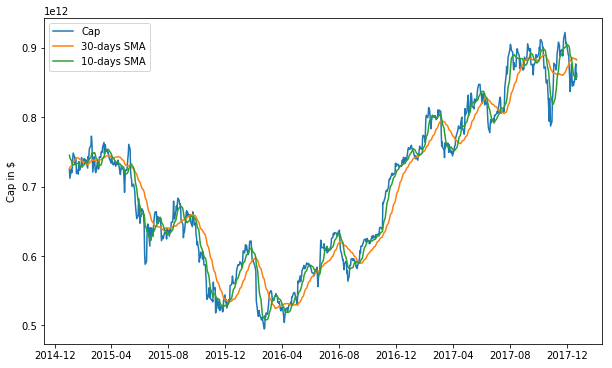

In [8]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

## Part 1: Model calibration with moving average signals (Max 10 points)

Recall the equation for the dynamics of market portfolio: 

$$ \Delta {\bf x}_t = \kappa_x \circ  {\bf x}_t \circ 
\left( {\bf W}{\bf z}_t'  - {\bf x}_t \right)  +  {\bf x}_t  \circ \varepsilon_t^{(x)} $$

Here we change the notation a bit. Now $ {\bf z}_t' $ is an extended vector of predictors that includes a constant unit predictor $  {\bf z}_t' = [1, {\bf z}_t ]^T $. Therefore, for each name, if you have $ K = 2 $ signals, an extended vector of signals $ {\bf z}_t' $ is of length $ K + 1 $, and the  $ W $ stands for a factor loading matrix.
The negative log-likelihood function for observable data with this model is therefore

$$  LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ (2 \pi)^{N}  \left| \Sigma_x \right| }} 
e^{ - \frac{1}{2} \left(   {\bf v}_t
 \right)^{T} 
\Sigma_x^{-1}  
\left(  {\bf v}_t \right)} $$

where

$$  {\bf v}_t \equiv \frac{{\bf x}_{t+1} -  {\bf x}_{t}}{{\bf x}_{t}}  
-  \kappa_x \circ \left({\bf W} {\bf z}_t'   - {\bf x}_t \right)  $$

and $ \Sigma_x $ is the covariance matrix that was specified above in terms of other parameters. Here we directly infer the value of $ \Sigma_x $, along with other parameters, from data, so we will not use these previous expressions. 

Parameters that you have to estimate from data are therefore the vector of mean reversion speed 
parameters $ \kappa_x $, factor loading matrix $ {\bf W} \equiv {\bf w}_z' $, and covariance matrix $ \Sigma_x $. 

Now, you are free to impose some structure on this parameters. Here are some choice, in the order of increasing complexity:

- assume that all values in vector-valued and matrix-valued parameters are the same, so that they can parametrized by scalars, e.g. $ \kappa_x = \kappa {\bf 1}_N $ where $ \kappa $ is a scalar value, and $ {\bf 1}_N $ is a vector of ones of length $ N $ where $ N $ is the number of stocks in the market portfolio. You can proceed similarly with specification of factor loading matrix $ W' $. Assume that all values in (diagonal!) factor loading matrices are the same for all names, and assume that all correlations and variances in the covariance matrix $ \Sigma_x $ are the same for all names.   

- Assume that all values are the same only within a given industrial sector.


- You can also change the units. For example, you can consider logs of market caps instead of market caps themselves, ie. change the variable from $ {\bf x}_t  $ to $ {\bf q}_t = \log {\bf x}_t $


In [9]:
# Put the rest of you code and analysis for Part I here 

In [10]:
# Following Section 6 & 7 of https://arxiv.org/abs/1805.06126
# and, https://www.coursera.org/learn/reinforcement-learning-in-finance/discussions/weeks/4/threads/JAdiMKAOEeiaohL5Azo1Vg

### 1.1 Data Processing

In [11]:
# Rescaling

average_market_cap = df_cap.sum(axis=1).mean()

df_cap_rescaled = df_cap / average_market_cap
short_rolling_rescaled = short_rolling / average_market_cap
long_rolling_rescaled = long_rolling / average_market_cap

In [12]:
# Calculating Pct Change

short_rolling_pct_change = short_rolling_rescaled.pct_change(periods=1)#.shift(-1)
long_rolling_pct_change = long_rolling_rescaled.pct_change(periods=1)#.shift(-1)

In [13]:
# Market Cap
market_cap = df_cap_rescaled.copy()
market_cap_next = df_cap_rescaled.shift(-1).dropna()

# Signals
signal_1 = short_rolling_pct_change.dropna()
signal_2 = long_rolling_pct_change.dropna()

# Get rid rows where dates that do not match
index = market_cap.index\
    .intersection(market_cap_next.index)\
    .intersection(signal_1.index)\
    .intersection(signal_2.index)

market_cap = market_cap.loc[index]
market_cap_next = market_cap_next.loc[index]
signal_1 = signal_1.loc[index]
signal_2 = signal_2.loc[index]

### 1.2 Fitting/Calibration

In [14]:
class MovingAverageCalibrationModel:
    """
    class MovingAverageCalibrationModel - implements maximum likelihood estimator (MLE) solution
    """
    def __init__(self, n_features, n_signals, learning_rate=0.05, sameWeights=True):
        # input placeholders
        self.X = tf.placeholder(tf.float32, [None, n_features], name="X") 
        self.Y = tf.placeholder(tf.float32, [None, n_features], name="Y")
        self.Z = tf.placeholder(tf.float32, [None, n_signals], name="Z")
        
        # Augmented signals matrix is obtained by adding a column of ones to the data matrix
        #signals_plus_bias = tf.concat([tf.ones([tf.shape(self.Z)[0], 1]), self.Z], axis=1)
        signals_plus_bias = tf.concat([tf.ones([tf.shape(self.Z)[0], 1]), self.Z], axis=1)
        
        # Estimate the model using the Maximum Likelihood Estimation (MLE)
        
        assert n_signals%n_features==0
        n_signal_types = n_signals//n_features
        
        tf.set_random_seed(97)
        
        # regression parameters for the Maximum Likelihood method
        if sameWeights:
            #self.k = tf.Variable(tf.random_normal([1]), name="k")
            #self.w = tf.Variable(tf.random_normal([n_signal_types]), name="w")
            #self.std = tf.Variable(tf.random_uniform([1], minval=0.01, maxval=0.05), name="std")
            self.k = tf.Variable(1., name="k")
            self.w = tf.Variable((1/n_signal_types)*tf.ones([n_signal_types]), name="w")
            self.std = tf.Variable(0.01, name="std")
            self.kx = tf.multiply(self.k, tf.ones([1, n_features]), name="kx")
            self.W = tf.concat( (
               [ tf.ones([1, n_features]), ] + 
               [ self.w[i] * tf.eye(n_features) for i in range(n_signal_types) ]
            ), axis = 0, name="X" )
            self.sigma_diag = tf.multiply( self.std, tf.ones([1, n_features]), name="sigma_diag")
        else:
            self.kx = tf.Variable(tf.random_normal([1, n_features]), name="kx")
            w = tf.Variable(tf.random_normal([n_signals]), name="w")
            self.W = tf.concat((
              [ tf.ones([1, n_features]), ] + 
              [ w[(i)*n_features:(i+1)*n_features] * tf.eye(n_features) for i in range(n_signal_types) ]
            ), axis = 0, name="W")
            self.sigma_diag = tf.Variable(tf.random_uniform([1, n_features], minval=0.01, maxval=0.05), name="sigma_diag")
        
        scale = tf.slice( self.X,
                   [0,0],
                   [1,-1] )
        
        self.theta = tf.multiply(scale, tf.cumprod(tf.matmul(signals_plus_bias, self.W)), name="theta")
        
        V = (self.Y - self.X)/self.X - tf.multiply(self.kx, self.theta - self.X)
        
        dist = tf.contrib.distributions.MultivariateNormalDiag(
            scale_diag=self.sigma_diag
        )
        
        log_LL = dist.log_prob(V)
        self.neg_log_LL = tf.negative(tf.reduce_mean(log_LL), name="neg_log_LL")
        
        self.train_step = (tf.train.AdamOptimizer(learning_rate).minimize(self.neg_log_LL), -self.neg_log_LL)

In [15]:
def run_mle(X, Y, Z, learning_rate=0.05, num_iter=5000, sameWeights=True):
    """
    Maximum likelihood Estimate (MLE)
    Tests the model quality by computing mean square error (MSE) of the test data set
    
    Arguments:
    X - np.array of size (T-1 by N) where N is number of ticker names and T is number of observations
    Y - np.array of size (T-1 by N) representing X[t+1,:]    
    Z - np.array of size (T-1 by k) where k is number of signals    
    
    Return a tuple of:
        - an object instance of MovingAverageCalibrationModel
        - np.arrays of weights/variables
        - log-likelihood
        - fitted mean reversion levels
    """
    # create an instance of the Moving Average Calibration Model class  
    n_features = X.shape[1]
    n_signals = Z.shape[1]
    model = MovingAverageCalibrationModel(n_features=n_features, n_signals=n_signals, learning_rate=learning_rate, sameWeights=sameWeights)
    
    tf.set_random_seed(97)
    
    # train the model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # Now train the MLE parameters 
        for i in range(num_iter+1):
            (_ , log_LL) = sess.run(model.train_step, feed_dict={
                model.X: X,
                model.Y: Y,
                model.Z: Z
                })
            if i%min(1000,(num_iter/20))==0:
                print("{:5} | {:16.4f}".format(i,log_LL))
        if sameWeights:
            log_LL, k, w, std, theta = sess.run(
                (-model.neg_log_LL, model.k, model.w, model.std, model.theta), 
                feed_dict={
                    model.X: X,
                    model.Y: Y,
                    model.Z: Z
                })
        else:
            log_LL, kx, W, sigma_diag, theta = sess.run(
                (-model.neg_log_LL, model.kx, model.W, model.sigma_diag, model.theta), 
                feed_dict={
                    model.X: X,
                    model.Y: Y,
                    model.Z: Z
                })
        
        sess.close()
    if sameWeights:
        return model, k, w, std, log_LL, theta
    else:
        return model, kx, W, sigma_diag, log_LL, theta

In [16]:
# max_window_MA = max(window_1, window_2)

# X = df_cap.iloc[(max_window_MA-1):-1, :]
# Y = df_cap.iloc[(max_window_MA-1)+1:, :]

# MASignals = pd.concat([short_rolling, long_rolling], axis=1)
# Z = MASignals.iloc[(max_window_MA-1):-1, :]

# idx_XnotO = (X != 0.).all(axis=1).values
# X_, Y_, Z_ = X[idx_XnotO], Y[idx_XnotO], Z[idx_XnotO]

# model, kx, W, sigma_diag, log_LL, theta = run_mle(X_, Y_, Z_, learning_rate=0.5)

In [17]:
X = market_cap
Y = market_cap_next

MASignals = pd.concat([signal_1, signal_2], axis=1)
Z = MASignals

In [18]:
model, k, w, std, log_LL, theta = run_mle(X, Y, Z, learning_rate=0.0001, sameWeights=True)

# model, kx, W, sigma_diag, log_LL, theta = run_mle(X, Y, Z, learning_rate=0.001, sameWeights=False)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
    0 |          80.4768

### 1.3 Calibration Results

In [19]:
# Calibrated Weights/Variables

w, std, k

# (array([ 0.84576565,  0.14499727], dtype=float32), 0.014135194, 0.61935335)

(array([ 0.84576565,  0.14499727], dtype=float32), 0.014135194, 0.61935335)

In [20]:
# For Re-run without Training

# model = MovingAverageCalibrationModel(n_features=X.shape[1], n_signals=Z.shape[1], learning_rate=0.0001, sameWeights=True)

# w, std, k = (np.array([ 0.84576565,  0.14499727], dtype=np.float32), 0.014135194, 0.61935335)

# with tf.Session() as sess:
#     theta = sess.run(
#             model.theta, 
#             feed_dict={
#                 model.X: X,
#                 model.Z: Z,
#                 model.w: w
#             })

In [21]:
# Fitted Mean Reversion Levels

# with tf.Session() as sess:
#     theta = sess.run(
#             model.theta, 
#             feed_dict={
#                 model.X: X,
#                 model.Z: Z,
#                 model.w: w
#             })

theta, theta.shape

(array([[ 0.03814317,  0.00964   ,  0.0097323 , ...,  0.01707656,
          0.04270227,  0.06433698],
        [ 0.03819343,  0.00965568,  0.00979245, ...,  0.01706298,
          0.04264728,  0.06426755],
        [ 0.03834215,  0.00968564,  0.00989019, ...,  0.01707438,
          0.04268216,  0.06434416],
        ..., 
        [ 0.18002202,  0.01677719,  0.04151102, ...,  0.04027799,
          0.05415063,  0.06523569],
        [ 0.18016875,  0.01676607,  0.04149362, ...,  0.04035054,
          0.05410093,  0.06531357],
        [ 0.18010575,  0.01676911,  0.04154576, ...,  0.04039444,
          0.05404025,  0.06541161]], dtype=float32), (2049, 30))

In [22]:
# Fitted Mean Reversion Levels (in USD)

mean_levels = pd.DataFrame(theta, columns=X.columns, index=X.index) * average_market_cap

### 1.4 Plotting (for analysis/comparision)

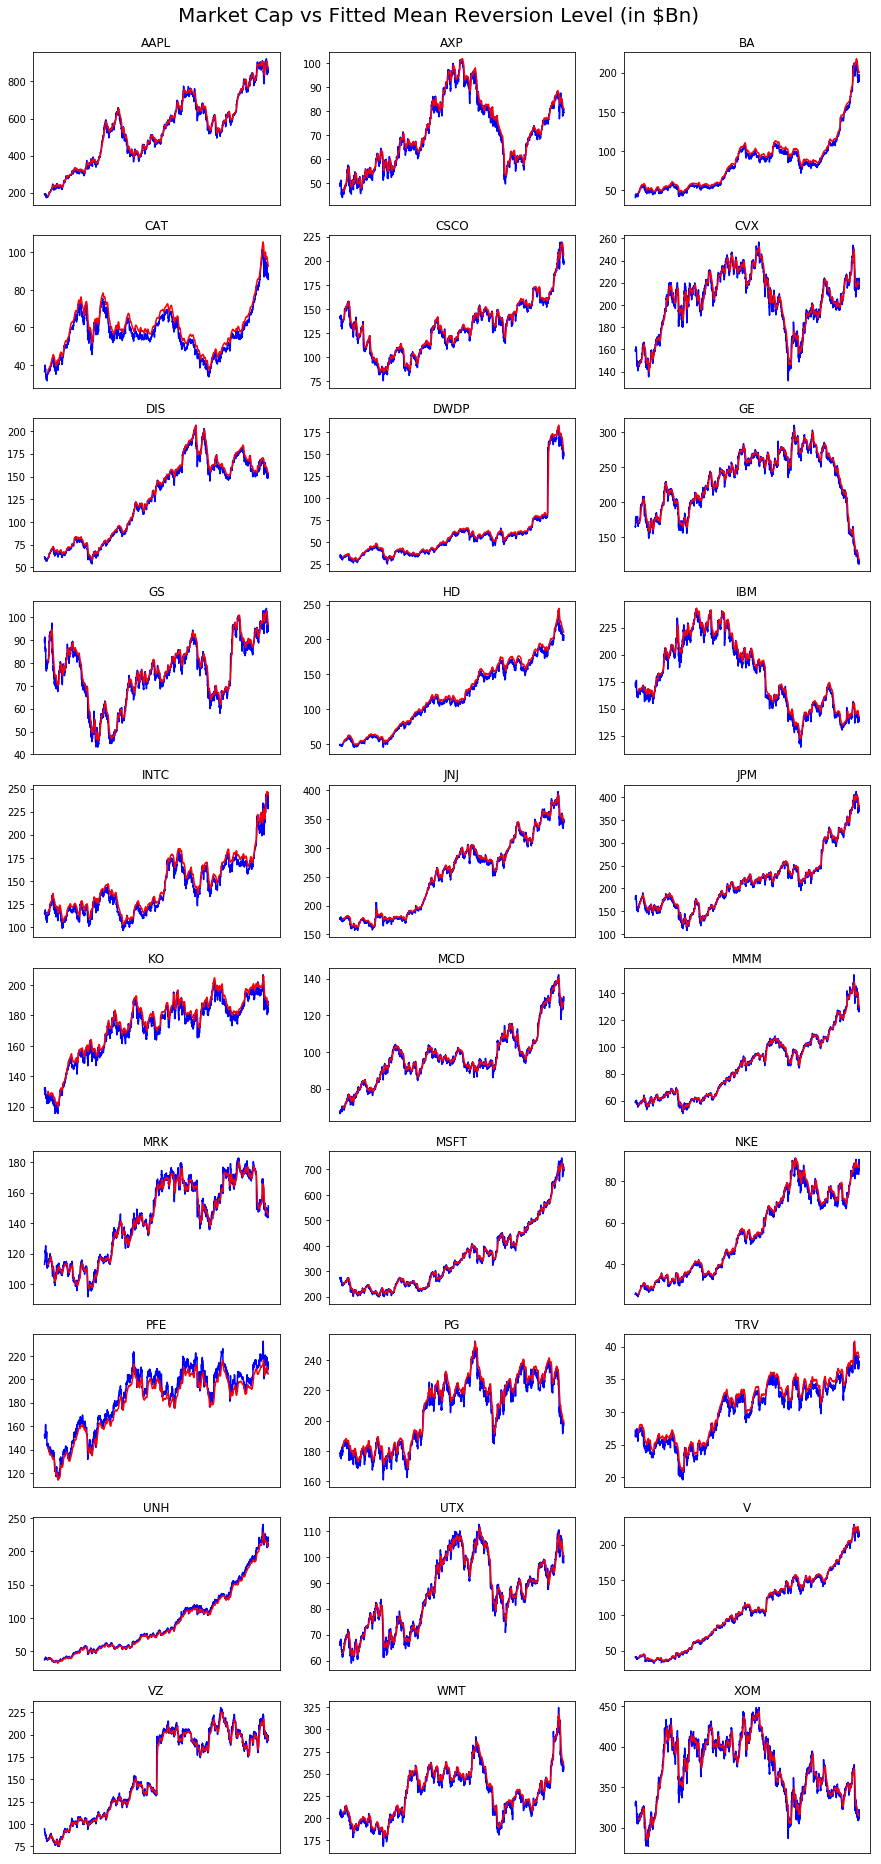

In [23]:
# Plotting Market Cap vs Fitted Mean Reversion Level (in USD Billions)

scale = 1e-9

N = df_cap.shape[1]

assert N == 30

plt.figure(figsize=(15,N))
plt.suptitle('Market Cap vs Fitted Mean Reversion Level (in $Bn)', size=20)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = df_cap.columns
for index, stock in enumerate(stocks,1):
    plt.subplot(np.ceil(N/3),3,index)
    plt.plot(scale*df_cap[stock],color='blue',label='Market cap')
    plt.plot(scale*mean_levels[stock],color='red',label='Mean reversion level')
    plt.title(stock,size=12)
    plt.xticks([])

plt.show()

## Part 2: Propose and analyse your own signals  (Max 10 points)

In this part, you will experiment with other signals. Propose a signal and explain why it is interesting to 
include this signal in the portfolio analysis. Then add your favorite signal or signals to the previous benchmarck signals (or alternatively you can replace them), and repeat the analysis of model calibration. State your conclusions.


In [24]:
# Put the rest of your code and analysis for Part 2 here.

### * Using Exponential Weighted Moving Average instead of standard Rolling Mean for signal.

### 2.1 Data Processing

In [25]:
# Exponential weighted moving average

ewma_short_rolling = df_cap.ewm(span=window_1, adjust=False).mean()
ewma_long_rolling = df_cap.ewm(span=window_2, adjust=False).mean()

In [26]:
# Rescaling

ewma_short_rolling_rescaled = ewma_short_rolling / average_market_cap
ewma_long_rolling_rescaled = ewma_long_rolling / average_market_cap

In [27]:
# Calculating Pct Change

ewma_short_rolling_pct_change = ewma_short_rolling_rescaled.pct_change(periods=1)#.shift(-1)
ewma_long_rolling_pct_change = ewma_long_rolling_rescaled.pct_change(periods=1)#.shift(-1)

In [28]:
# Market Cap
market_cap_2 = df_cap_rescaled.copy()
market_cap_next_2 = df_cap_rescaled.shift(-1).dropna()

# Signals
signal_3 = ewma_short_rolling_pct_change.dropna()
signal_4 = ewma_long_rolling_pct_change.dropna()

# Get rid rows where dates that do not match
index2 = market_cap_2.index\
    .intersection(market_cap_next_2.index)\
    .intersection(signal_3.index)\
    .intersection(signal_4.index)

market_cap_2 = market_cap_2.loc[index2]
market_cap_next_2 = market_cap_next_2.loc[index2]
signal_3 = signal_3.loc[index2]
signal_4 = signal_4.loc[index2]

### 2.2 Fitting/Calibration

In [29]:
X2 = market_cap_2
Y2 = market_cap_next_2

EWMASignals = pd.concat([signal_3, signal_4], axis=1)
Z2 = EWMASignals

In [30]:
model_2, k_2, w_2, std_2, log_LL_2, theta_2 = run_mle(X2, Y2, Z2, learning_rate=0.0001, sameWeights=True)

# model_2, kx_2, W_2, sigma_diag_2, log_LL_2, theta_2 = run_mle(X2, Y2, Z2, learning_rate=0.001, sameWeights=False)

    0 |          80.3606
  250 |          85.0832
  500 |          85.0859
  750 |          85.0884
 1000 |          85.0909
 1250 |          85.0933
 1500 |          85.0955
 1750 |          85.0977
 2000 |          85.0997
 2250 |          85.1016
 2500 |          85.1033
 2750 |          85.1050
 3000 |          85.1065
 3250 |          85.1080
 3500 |          85.1093
 3750 |          85.1106
 4000 |          85.1117
 4250 |          85.1127
 4500 |          85.1137
 4750 |          85.1145
 5000 |          85.1153


### 2.3 Calibration Results

In [31]:
# Calibrated Weights/Variables

w_2, std_2, k_2

# (array([ 0.6193974 ,  0.39064038], dtype=float32), 0.014177273, 0.58487201)

(array([ 0.6193974 ,  0.39064038], dtype=float32), 0.014177273, 0.58487201)

In [32]:
# For Re-run without Training

# model_2 = MovingAverageCalibrationModel(n_features=X2.shape[1], n_signals=Z2.shape[1], learning_rate=0.0001, sameWeights=True)

# w_2, std_2, k_2 = (np.array([ 0.6193974 ,  0.39064038], dtype=np.float32), 0.014177273, 0.58487201)

# with tf.Session() as sess:
#     theta_2 = sess.run(
#             model_2.theta, 
#             feed_dict={
#                 model_2.X: X2,
#                 model_2.Z: Z2,
#                 model_2.w: w_2
#             })

In [33]:
# Fitted Mean Reversion Levels

# with tf.Session() as sess:
#     theta_2 = sess.run(
#             model_2.theta, 
#             feed_dict={
#                 model_2.X: X2,
#                 model_2.Z: Z2,
#                 model_2.w: w_2
#             })

theta_2, theta_2.shape

(array([[ 0.04021131,  0.01005393,  0.00877148, ...,  0.01962164,
          0.04231418,  0.06807662],
        [ 0.04013107,  0.01007372,  0.00884223, ...,  0.01951038,
          0.04225243,  0.06818871],
        [ 0.04005359,  0.01010693,  0.00895339, ...,  0.01940144,
          0.04220368,  0.06825306],
        ..., 
        [ 0.18275629,  0.01673896,  0.04221586, ...,  0.04133833,
          0.05367076,  0.06582979],
        [ 0.18313029,  0.01676386,  0.04234805, ...,  0.04140114,
          0.05366441,  0.06602474],
        [ 0.18278535,  0.01672737,  0.04227505, ...,  0.04136189,
          0.05356101,  0.0660456 ]], dtype=float32), (2078, 30))

In [34]:
# Fitted Mean Reversion Levels (in USD)

mean_levels_2 = pd.DataFrame(theta_2, columns=X2.columns, index=X2.index) * average_market_cap

### 2.4 Plotting (for analysis/comparision)

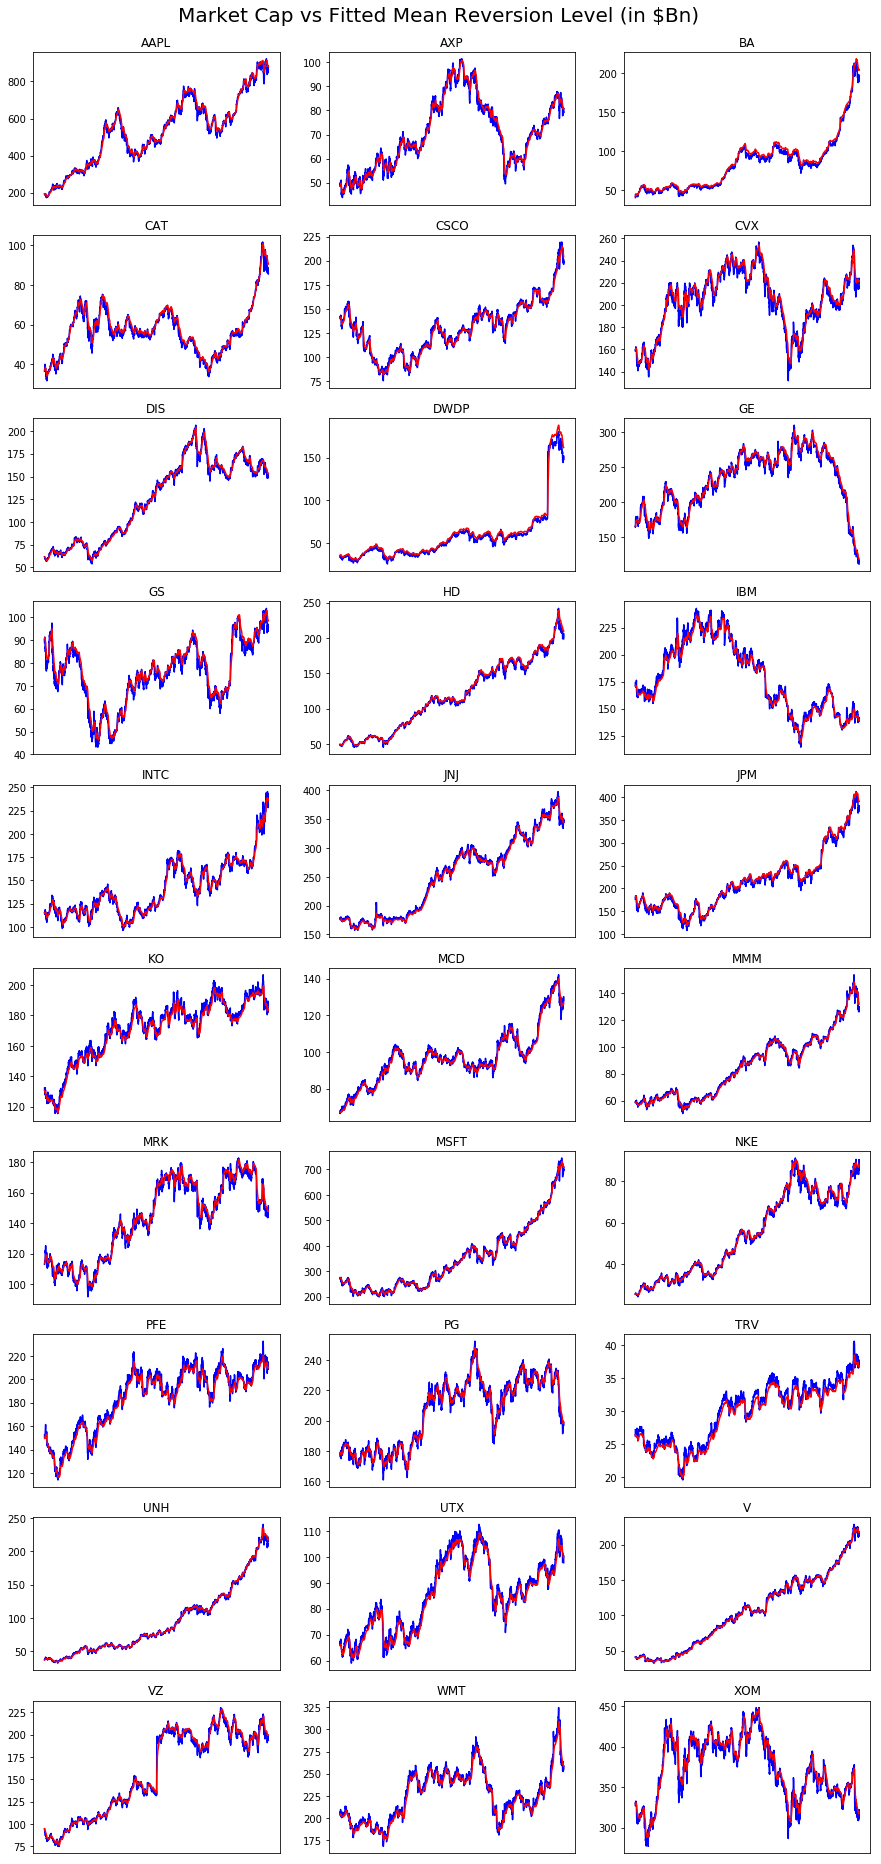

In [35]:
# Plotting Market Cap vs Fitted Mean Reversion Level (in USD Billions)

scale = 1e-9

N = df_cap.shape[1]

assert N == 30

plt.figure(figsize=(15,N))
plt.suptitle('Market Cap vs Fitted Mean Reversion Level (in $Bn)', size=20)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = df_cap.columns
for index, stock in enumerate(stocks,1):
    plt.subplot(np.ceil(N/3),3,index)
    plt.plot(scale*df_cap[stock],color='blue',label='Market cap')
    plt.plot(scale*mean_levels_2[stock],color='red',label='Mean reversion level')
    plt.title(stock,size=12)
    plt.xticks([])

plt.show()

## Part 3: Can you do it for the S&P500 market portfolio? (Max 10 point)

Try to repeat your analysis for the S&P500 portfolio. 

The data can be obtained from Course 2 "Fundamentals of Machine Learning in Finance" in this Specialization.

In [36]:
# Put the rest of your code and analysis for Part 3 here.

In [37]:
# read the data to a Dataframe
df_spx = pd.read_csv('spx_holdings_and_spx_closeprice.csv',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0).dropna()

In [38]:
df_spx.shape

(3493, 419)

In [39]:
df_spx

,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,...,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
2000-01-27,46.1112,78.9443,3.9286,4.5485,13.7898,15.6719,48.0313,10.8844,39.5477,8.1250,...,5.5918,86.6178,26.3983,11.3873,65.8677,22.1921,60.9705,20.7086,12.2457,1398.56
2000-01-28,45.8585,77.8245,3.6295,4.5485,14.2653,14.3906,47.7500,10.7143,38.5627,7.7188,...,5.4520,82.4218,27.4137,11.2230,60.3487,21.7558,62.3032,20.1183,12.0742,1360.16
2000-01-31,44.5952,78.0345,3.7054,4.3968,14.5730,13.7656,46.7500,10.6576,37.3807,7.6406,...,5.5499,86.3181,28.2444,11.0862,62.1484,22.0533,60.6373,19.5772,12.1722,1394.46
2000-02-01,47.8377,80.7640,3.5804,4.5333,14.7128,13.9688,49.0000,10.8844,37.9717,7.9219,...,5.4240,83.0212,28.7982,11.1683,67.3674,22.2120,60.4708,19.5772,12.5151,1409.28
2000-02-02,51.5434,83.4934,3.5290,4.5788,14.7968,15.3281,48.1250,10.6576,35.9032,7.9688,...,5.3541,81.5226,28.6136,11.1956,68.9271,22.6483,62.4698,19.5281,12.3192,1409.12
2000-02-03,52.3856,80.9039,3.6897,4.5485,14.8807,17.2656,52.8750,10.6576,38.3165,8.2500,...,5.4939,80.6235,28.4290,11.3599,72.2265,22.7871,61.1371,19.2329,12.6375,1424.97
2000-02-04,51.3750,78.9443,3.8571,4.4727,15.4121,18.5000,55.7500,10.6576,37.8240,8.1719,...,5.6337,80.3238,28.7982,11.3051,69.8269,22.8664,62.3032,19.1345,13.2743,1424.37
2000-02-07,53.5647,76.2848,4.0737,4.4423,15.1324,19.2656,59.5000,10.6576,36.6420,9.1406,...,5.4660,80.9232,28.3367,11.2230,73.8462,22.1326,60.8039,18.7902,13.0294,1424.24
2000-02-08,53.2279,73.8353,4.1027,4.3362,15.2723,20.9375,57.3750,10.6009,36.6912,9.8750,...,5.4939,82.1220,28.1059,11.1956,74.3861,22.4103,61.1371,18.7410,13.1274,1441.72
2000-02-09,51.0381,72.3656,4.0223,4.1846,16.1394,21.8906,57.8438,10.2041,35.4600,9.5156,...,5.3541,80.6235,27.7367,11.1409,71.9865,22.0533,59.6378,18.6918,12.8090,1411.70


### 3.1 Data Processing

In [40]:
# Moving Averages

short_rolling_spx = df_spx.rolling(window=window_1).mean()
long_rolling_spx = df_spx.rolling(window=window_2).mean()

ewma_short_rolling_spx = df_spx.ewm(span=window_1, adjust=False).mean()
ewma_long_rolling_spx = df_spx.ewm(span=window_2, adjust=False).mean()

In [41]:
# Rescaling

average_price_spx = df_spx.mean(axis=0)

df_spx_rescaled = df_spx / average_price_spx
short_rolling_spx_rescaled = short_rolling_spx / average_price_spx
long_rolling_spx_rescaled = long_rolling_spx / average_price_spx
ewma_short_rolling_spx_rescaled = ewma_short_rolling_spx / average_price_spx
ewma_long_rolling_spx_rescaled = ewma_long_rolling_spx / average_price_spx

In [42]:
# Calculating Pct Change

short_rolling_spx_pct_change = short_rolling_spx_rescaled.pct_change(periods=1)#.shift(-1)
long_rolling_spx_pct_change = long_rolling_spx_rescaled.pct_change(periods=1)#.shift(-1)
ewma_short_rolling_spx_pct_change = ewma_short_rolling_spx_rescaled.pct_change(periods=1)#.shift(-1)
ewma_long_rolling_spx_pct_change = ewma_long_rolling_spx_rescaled.pct_change(periods=1)#.shift(-1)

In [43]:
# Market Price
market_price_spx = df_spx_rescaled.copy()
market_price_spx_next = df_spx_rescaled.shift(-1).dropna()

# Signals
signal_spx_1 = short_rolling_spx_pct_change.dropna()
signal_spx_2 = long_rolling_spx_pct_change.dropna()
signal_spx_3 = ewma_short_rolling_spx_pct_change.dropna()
signal_spx_4 = ewma_long_rolling_spx_pct_change.dropna()

# Get rid rows where dates that do not match
index3 = market_price_spx.index\
    .intersection(market_price_spx_next.index)\
    .intersection(signal_spx_1.index)\
    .intersection(signal_spx_2.index)\
    .intersection(signal_spx_3.index)\
    .intersection(signal_spx_4.index)

market_price_spx = market_price_spx.loc[index3]
market_price_spx_next = market_price_spx_next.loc[index3]
signal_spx_1 = signal_spx_1.loc[index3]
signal_spx_2 = signal_spx_2.loc[index3]
signal_spx_3 = signal_spx_3.loc[index3]
signal_spx_4 = signal_spx_4.loc[index3]

### 3.2 Fitting/Calibration

In [44]:
X3 = market_price_spx
Y3 = market_price_spx_next

AllMASignals = pd.concat([signal_spx_1, signal_spx_2, signal_spx_3, signal_spx_4], axis=1)
Z3 = AllMASignals

In [45]:
model_3, k_3, w_3, std_3, log_LL_3, theta_3 = run_mle(X3, Y3, Z3, learning_rate=0.0001, sameWeights=True)

# model_3, kx_3, W_3, sigma_diag_3, log_LL_3, theta_3 = run_mle(X3, Y3, Z3, learning_rate=0.001, sameWeights=False)

    0 |      -39914.4453
  250 |       -6542.5522
  500 |       -3544.4734
  750 |       -2307.3381
 1000 |       -1616.2678
 1250 |       -1170.4083
 1500 |        -857.1672
 1750 |        -624.3636
 2000 |        -444.2777
 2250 |        -300.7756
 2500 |        -183.8063
 2750 |         -86.7490
 3000 |          -5.0516
 3250 |          64.5121
 3500 |         124.3164
 3750 |         176.1300
 4000 |         221.3283
 4250 |         260.9727
 4500 |         295.9266
 4750 |         326.8828
 5000 |         354.4210


### 3.3 Calibration Results

In [46]:
# Calibrated Weights/Variables

w_3, std_3, k_3

# (array([ 0.42126036,  0.05004425,  0.42703909,  0.10218517], dtype=float32),
#  0.067172267,
#  0.81037092)

(array([ 0.42126036,  0.05004425,  0.42703909,  0.10218517], dtype=float32),
 0.067172267,
 0.81037092)

In [47]:
# For Re-run without Training

# model_3 = MovingAverageCalibrationModel(n_features=X3.shape[1], n_signals=Z3.shape[1], learning_rate=0.0001, sameWeights=True)

# w_3, std_3, k_3 = \
# (np.array([ 0.42126036,  0.05004425,  0.42703909,  0.10218517], dtype=np.float32),
#  0.067172267,
#  0.81037092)

# with tf.Session() as sess:
#     theta_3 = sess.run(
#             model_3.theta, 
#             feed_dict={
#                 model_3.X: X3,
#                 model_3.Z: Z3,
#                 model_3.w: w_3
#             })

In [48]:
# Fitted Mean Reversion Levels

# with tf.Session() as sess:
#     theta_3 = sess.run(
#             model_3.theta, 
#             feed_dict={
#                 model_3.X: X3,
#                 model_3.Z: Z3,
#                 model_3.w: w_3
#             })

theta_3, theta_3.shape

(array([[ 4.1042366 ,  1.39391029,  0.19518648, ...,  0.44664204,
          0.4219723 ,  1.13386309],
        [ 4.15567589,  1.39141142,  0.19572397, ...,  0.44550097,
          0.42086539,  1.13525069],
        [ 4.16185713,  1.37319291,  0.19472837, ...,  0.44472939,
          0.42059702,  1.13335931],
        ..., 
        [ 1.94075084,  0.39231631,  3.6430397 , ...,  0.67802888,
          1.72971475,  1.47158647],
        [ 1.95648074,  0.39434212,  3.636693  , ...,  0.67896658,
          1.73726583,  1.47391653],
        [ 1.96852708,  0.39693308,  3.62485647, ...,  0.68450648,
          1.74379122,  1.47611415]], dtype=float32), (3462, 419))

In [49]:
# Fitted Mean Reversion Levels (in USD)

mean_levels_3 = pd.DataFrame(theta_3, columns=X3.columns, index=X3.index) * average_price_spx

### 3.4 Plotting (for analysis/comparision)

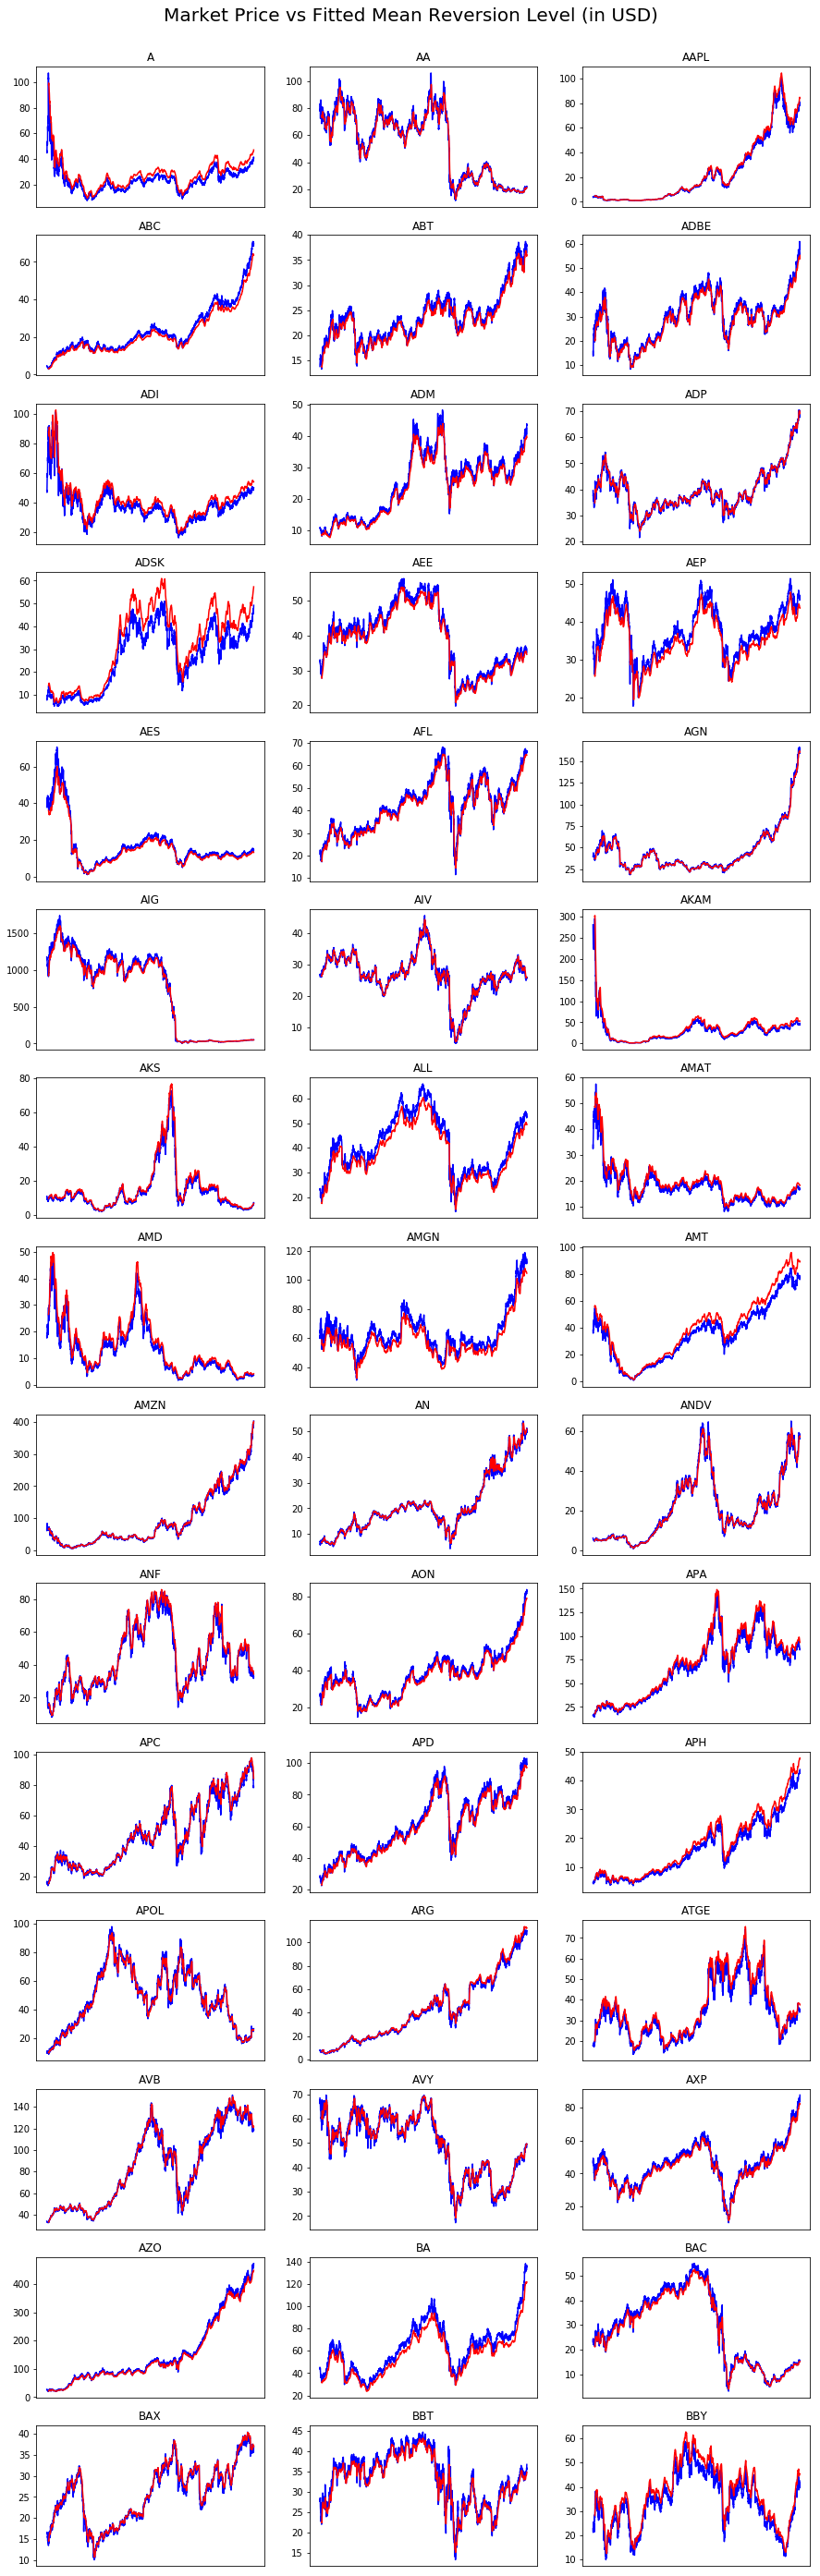

In [50]:
# Plotting Market Price vs Fitted Mean Reversion Level (in USD)

scale = 1

N = min(df_spx.shape[1], 45)

plt.figure(figsize=(15,N))
plt.suptitle('Market Price vs Fitted Mean Reversion Level (in USD)', size=20)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = df_spx.columns
for index, stock in enumerate(stocks[:N],1):
    plt.subplot(np.ceil(N/3),3,index)
    plt.plot(scale*df_spx[stock],color='blue',label='Market price')
    plt.plot(scale*mean_levels_3[stock],color='red',label='Mean reversion level')
    plt.title(stock,size=12)
    plt.xticks([])

plt.show()

## Part 4 (Optional): Show me something else.

Here you can develop any additional analysis of the model that you may find interesting (One possible suggestion is 
presented above, but you should feel free to choose your own topic). Present your case and finding/conclusions.


In [51]:
# Put the rest of your code and analysis for Part 3 here.

### * Consider logs of market caps instead of market caps themselves.

### 4.1 Data Processing

In [52]:
# Taking logarithm of market cap values

df_log_cap = df_cap.applymap(np.log)

In [53]:
df_log_cap.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,25.989854,24.608140,24.432446,24.319501,25.679313,25.789749,24.845338,24.231041,25.826199,25.211647,...,23.965790,25.752110,25.908282,24.027028,24.324363,24.930283,24.445025,25.272255,26.054174,26.513870
2010-01-05,25.991581,24.605938,24.464673,24.331386,25.674848,25.796807,24.842841,24.274628,25.831364,25.229172,...,23.969760,25.737744,25.908609,24.003053,24.322776,24.915232,24.433500,25.274056,26.044167,26.517767
2010-01-06,25.975547,24.621973,24.494556,24.334420,25.668318,25.796933,24.837513,24.292189,25.826199,25.218442,...,23.963645,25.734523,25.903855,23.988763,24.332575,24.909975,24.419980,25.230531,26.041929,26.526373
2010-01-07,25.973697,24.633714,24.534240,24.338450,25.672812,25.793158,24.837827,24.292834,25.876683,25.237821,...,23.987989,25.730753,25.898417,24.003053,24.370234,24.914240,24.429244,25.224561,26.042489,26.523226
2010-01-08,25.980323,24.632999,24.524547,24.349616,25.678098,25.794922,24.839396,24.296371,25.897993,25.218729,...,23.986013,25.738815,25.897094,24.001613,24.360798,24.916224,24.432007,25.225191,26.037439,26.519207


In [54]:
# Moving Averages

short_rolling_log_cap = df_log_cap.rolling(window=window_1).mean()
long_rolling_log_cap = df_log_cap.rolling(window=window_2).mean()

ewma_short_rolling_log_cap = df_log_cap.ewm(span=window_1, adjust=False).mean()
ewma_long_rolling_log_cap = df_log_cap.ewm(span=window_2, adjust=False).mean()

In [55]:
# Rescaling

average_log_market_cap = df_log_cap.mean(axis=0)

df_log_cap_rescaled = df_log_cap / average_log_market_cap
short_rolling_log_cap_rescaled = short_rolling_log_cap / average_log_market_cap
long_rolling_log_cap_rescaled = long_rolling_log_cap / average_log_market_cap
ewma_short_rolling_log_cap_rescaled = ewma_short_rolling_log_cap / average_log_market_cap
ewma_long_rolling_log_cap_rescaled = ewma_long_rolling_log_cap / average_log_market_cap

In [56]:
# Calculating Pct Change

short_rolling_log_cap_pct_change = short_rolling_log_cap_rescaled.pct_change(periods=1)#.shift(-1)
long_rolling_log_cap_pct_change = long_rolling_log_cap_rescaled.pct_change(periods=1)#.shift(-1)
ewma_short_rolling_log_cap_pct_change = ewma_short_rolling_log_cap_rescaled.pct_change(periods=1)#.shift(-1)
ewma_long_rolling_log_cap_pct_change = ewma_long_rolling_log_cap_rescaled.pct_change(periods=1)#.shift(-1)

In [57]:
# Log Market Cap
log_market_cap = df_log_cap_rescaled.copy()
log_market_cap_next = df_log_cap_rescaled.shift(-1).dropna()

# Signals
signal_log_cap_1 = short_rolling_log_cap_pct_change.dropna()
signal_log_cap_2 = long_rolling_log_cap_pct_change.dropna()
signal_log_cap_3 = ewma_short_rolling_log_cap_pct_change.dropna()
signal_log_cap_4 = ewma_long_rolling_log_cap_pct_change.dropna()

# Get rid rows where dates that do not match
index4 = log_market_cap.index\
    .intersection(log_market_cap_next.index)\
    .intersection(signal_log_cap_1.index)\
    .intersection(signal_log_cap_2.index)\
    .intersection(signal_log_cap_3.index)\
    .intersection(signal_log_cap_4.index)

log_market_cap = log_market_cap.loc[index4]
log_market_cap_next = log_market_cap_next.loc[index4]
signal_log_cap_1 = signal_log_cap_1.loc[index4]
signal_log_cap_2 = signal_log_cap_2.loc[index4]
signal_log_cap_3 = signal_log_cap_3.loc[index4]
signal_log_cap_4 = signal_log_cap_4.loc[index4]

### 4.2 Fitting/Calibration

In [58]:
X4 = log_market_cap
Y4 = log_market_cap_next

AllLCMASignals = pd.concat([signal_log_cap_1, signal_log_cap_2, signal_log_cap_3, signal_log_cap_4], axis=1)
Z4 = AllLCMASignals

In [59]:
model_4, k_4, w_4, std_4, log_LL_4, theta_4 = run_mle(X4, Y4, Z4, learning_rate=0.0001, sameWeights=True)

# model_4, kx_4, W_4, sigma_diag_4, log_LL_4, theta_4 = run_mle(X4, Y4, Z4, learning_rate=0.001, sameWeights=False)

    0 |         110.2863
  250 |         156.2989
  500 |         157.6337
  750 |         158.8510
 1000 |         159.9906
 1250 |         161.0733
 1500 |         162.0960
 1750 |         163.0595
 2000 |         163.9964
 2250 |         164.8858
 2500 |         165.7583
 2750 |         166.6137
 3000 |         167.4597
 3250 |         168.3004
 3500 |         169.1246
 3750 |         169.9539
 4000 |         170.7826
 4250 |         171.5985
 4500 |         172.4132
 4750 |         173.2179
 5000 |         174.0014


### 4.3 Calibration Results

In [60]:
# Calibrated Weights/Variables

w_4, std_4, k_4

# (array([ 0.31121203, -0.01823064,  0.67623872,  0.00540987], dtype=float32),
#  0.00073156069,
#  0.47621349)

(array([ 0.31121203, -0.01823064,  0.67623872,  0.00540987], dtype=float32),
 0.00073156069,
 0.47621349)

In [61]:
# For Re-run without Training

# model_4 = MovingAverageCalibrationModel(n_features=X4.shape[1], n_signals=Z4.shape[1], learning_rate=0.0001, sameWeights=True)

# w_4, std_4, k_4 = \
# (np.array([ 0.31121203, -0.01823064,  0.67623872,  0.00540987], dtype=np.float32),
#  0.00073156069,
#  0.47621349)

# with tf.Session() as sess:
#     theta_4 = sess.run(
#             model_4.theta, 
#             feed_dict={
#                 model_4.X: X4,
#                 model_4.Z: Z4,
#                 model_4.w: w_4
#             })

In [62]:
# Fitted Mean Reversion Levels

# with tf.Session() as sess:
#     theta_4 = sess.run(
#             model_4.theta, 
#             feed_dict={
#                 model_4.X: X4,
#                 model_4.Z: Z4,
#                 model_4.w: w_4
#             })

theta_4, theta_4.shape

(array([[ 0.96335059,  0.98444307,  0.97996807, ...,  0.97707969,
          0.99668914,  0.99354589],
        [ 0.96345234,  0.9845522 ,  0.98030502, ...,  0.97708738,
          0.99667645,  0.99356741],
        [ 0.96354634,  0.98465896,  0.98070747, ...,  0.97708958,
          0.99669391,  0.99360901],
        ..., 
        [ 1.01989317,  1.00615358,  1.03638971, ...,  1.00996172,
          1.00550997,  0.99408227],
        [ 1.0199815 ,  1.00621665,  1.0365181 , ...,  1.01004899,
          1.00552249,  0.99420905],
        [ 1.01992416,  1.00616014,  1.0364989 , ...,  1.01004016,
          1.00547016,  0.99425191]], dtype=float32), (2049, 30))

In [63]:
# Fitted Mean Reversion Levels

mean_levels_4 = pd.DataFrame(theta_4, columns=X4.columns, index=X4.index) * average_log_market_cap

### 4.4 Plotting (for analysis/comparision)

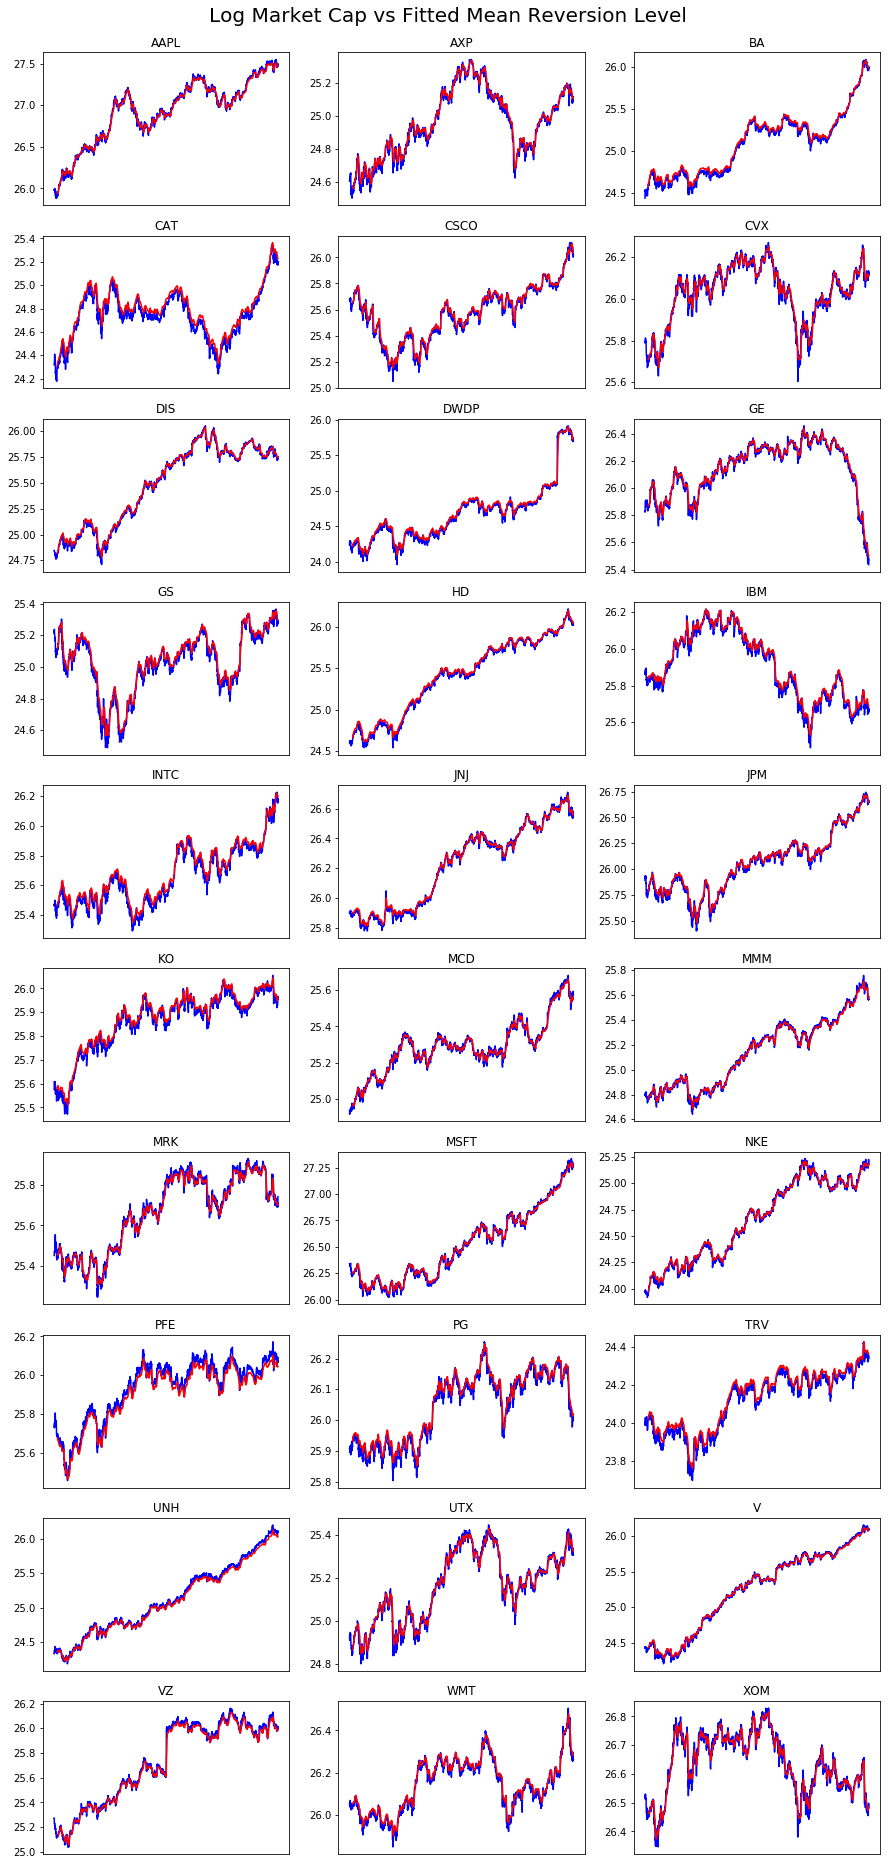

In [64]:
# Plotting Log Market Cap vs Fitted Mean Reversion Level

scale = 1

N = df_log_cap.shape[1]

plt.figure(figsize=(15,N))
plt.suptitle('Log Market Cap vs Fitted Mean Reversion Level', size=20)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = df_log_cap.columns
for index, stock in enumerate(stocks,1):
    plt.subplot(np.ceil(N/3),3,index)
    plt.plot(scale*df_log_cap[stock],color='blue',label='Market price')
    plt.plot(scale*mean_levels_4[stock],color='red',label='Mean reversion level')
    plt.title(stock,size=12)
    plt.xticks([])

plt.show()

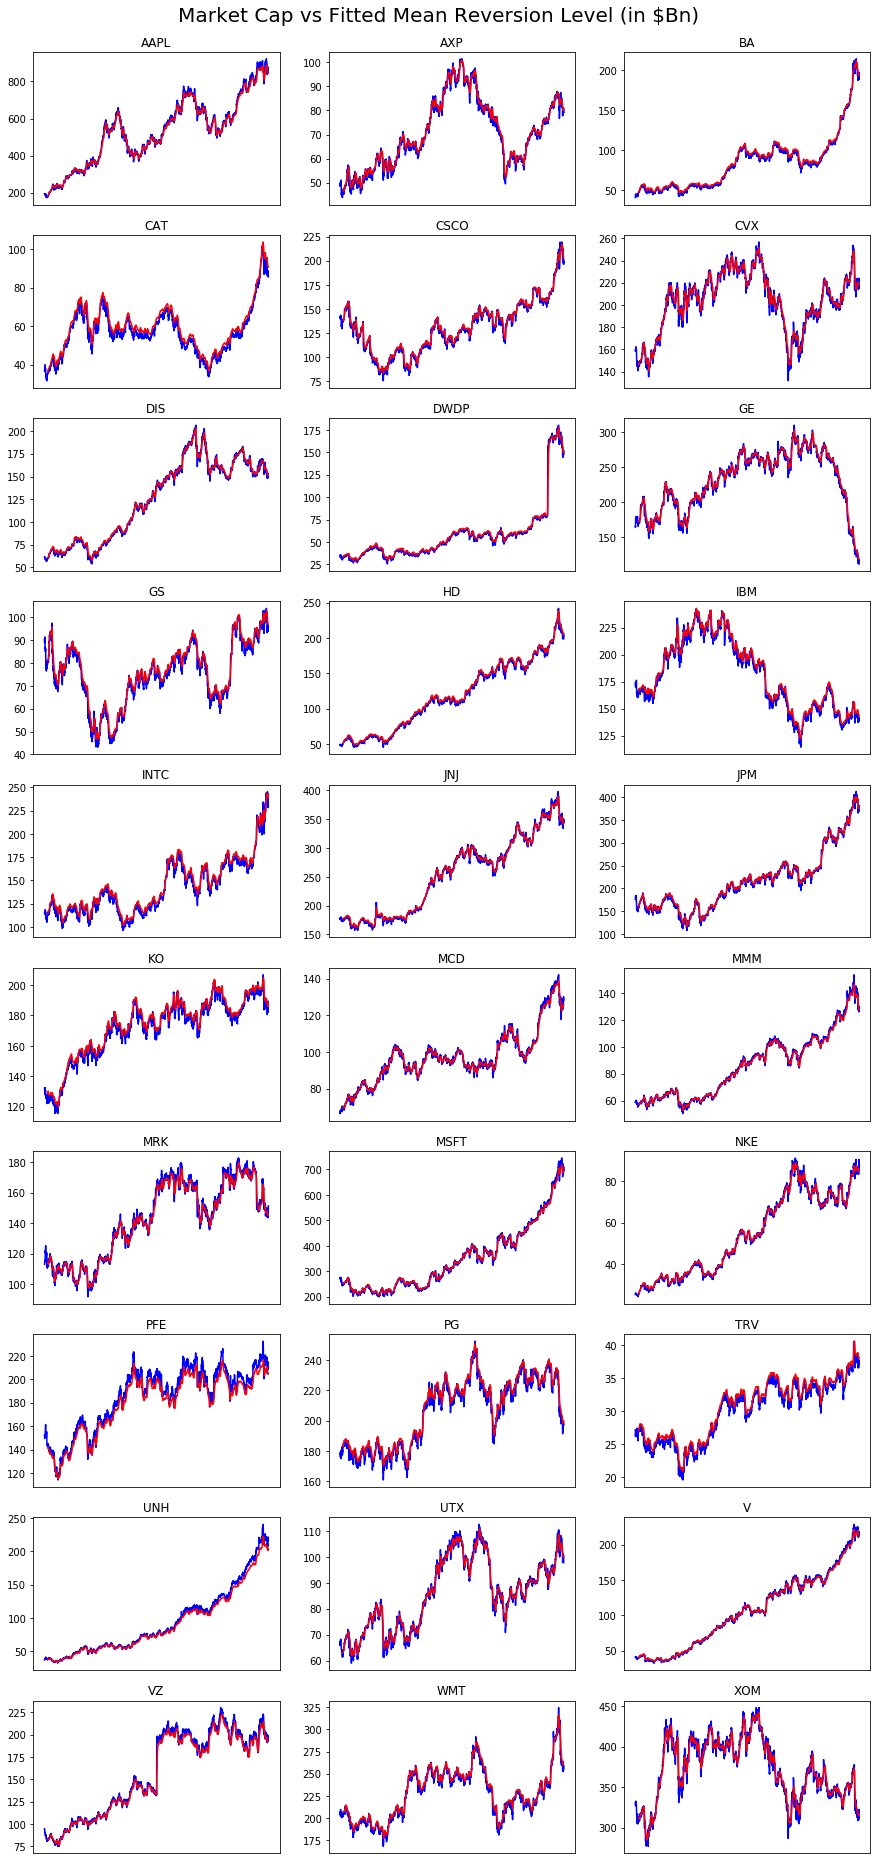

In [65]:
# Plotting Market Cap vs Fitted Mean Reversion Level (in USD Billions)

scale = 1e-9

N = df_log_cap.shape[1]

plt.figure(figsize=(15,N))
plt.suptitle('Market Cap vs Fitted Mean Reversion Level (in $Bn)', size=20)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = df_log_cap.columns
for index, stock in enumerate(stocks,1):
    plt.subplot(np.ceil(N/3),3,index)
    plt.plot(scale*df_log_cap[stock].apply(np.exp),color='blue',label='Market price')
    plt.plot(scale*mean_levels_4[stock].apply(np.exp),color='red',label='Mean reversion level')
    plt.title(stock,size=12)
    plt.xticks([])

plt.show()